# Baseline модель на данных application

Анализ таблицы: application.ipynb

In [8]:
import pandas as pd
import numpy as np
from copy import deepcopy

import lightgbm as lgb
from sklearn.model_selection import train_test_split
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import helpers

In [9]:
def add_renamed(feature, application_df, resultive_df,
                application_features_numeric, application_features_categorical):
    assert resultive_df[resultive_df[feature].isna()].shape[0] == 0
    application_features_numeric.append('application__{}'.format(feature))
    resultive_df['application__{}'.format(feature)] = resultive_df[feature]
    resultive_df.drop([feature], axis=1, inplace=True)

def add_renamed_nan(feature, application_df, resultive_df,
                    application_features_numeric, application_features_categorical):
    application_features_numeric.append('application__{}'.format(feature))
    resultive_df['application__{}'.format(feature)] = resultive_df[feature]
    resultive_df.drop([feature], axis=1, inplace=True)

def add_quantile_nan(feature, quantile_dict, application_df, resultive_df, 
                     application_features_numeric, application_features_categorical):
    application_features_numeric.append('application__{}'.format(feature))
    resultive_df['application__{}'.format(feature)] = resultive_df[feature]
    if quantile_dict is None:
        ql, qr = resultive_df[feature].quantile(0.01), resultive_df[feature].quantile(0.99)
    else:
        ql, qr = quantile_dict[feature]
    resultive_df.loc[resultive_df[feature] > qr, feature] = qr
    resultive_df.loc[resultive_df[feature] < ql, feature] = ql
    resultive_df.drop([feature], axis=1, inplace=True)
    return ql, qr

def add_one_hot(feature, quantile_dict, qd, application_df, resultive_df, 
                application_features_numeric, application_features_categorical):
    cats = np.unique(
            resultive_df[~resultive_df[feature].isna()][feature])
    if quantile_dict is not None:
        cats = quantile_dict[feature]
    qd[feature] = cats
    for cat in cats:
        application_features_numeric.append('application__{}__{}'.format(feature, cat))
        resultive_df['application__{}__{}'.format(feature, cat)] = \
                (resultive_df[feature] == cat).astype(float)
    if application_df[application_df[feature].isna()].shape[0] != 0:
        application_features_numeric.append('application__{}__{}'.format(feature, 'nan'))
        resultive_df['application__{}__{}'.format(feature, 'nan')] = \
                (resultive_df[feature].isna()).astype(float)
    resultive_df.drop([feature], axis=1, inplace=True)
    
def add_NAME_TYPE_SUITE(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical):
    resultive_df.loc[resultive_df['NAME_TYPE_SUITE'] != 'Unaccompanied',
                     'NAME_TYPE_SUITE'] = 'Accompanied'
    resultive_df['application__NAME_TYPE_SUITE__Accompanied'] = \
                (resultive_df['NAME_TYPE_SUITE'] == 'Accompanied').astype(float)
    resultive_df['application__NAME_TYPE_SUITE__Unaccompanied'] = \
                (resultive_df['NAME_TYPE_SUITE'] == 'Unaccompanied').astype(float)
    application_features_numeric.append('application__NAME_TYPE_SUITE__Accompanied')
    application_features_numeric.append('application__NAME_TYPE_SUITE__Unaccompanied')
    resultive_df.drop(['NAME_TYPE_SUITE'], axis=1, inplace=True)
    
def add_OWN_CAR_AGE(application_df, resultive_df, 
                    application_features_numeric, application_features_categorical):
    application_features_numeric.append('application__OWN_CAR_AGE__0_8')
    resultive_df['application__OWN_CAR_AGE__0_8'] = (
            (application_df['OWN_CAR_AGE'] <= 8) &\
            (~application_df['OWN_CAR_AGE'].isna())
    ).astype(float)
    application_features_numeric.append('application__OWN_CAR_AGE__8_12')
    resultive_df['application__OWN_CAR_AGE__8_12'] = (
            (application_df['OWN_CAR_AGE'] > 8) & (application_df['OWN_CAR_AGE'] <= 12) &\
            (~application_df['OWN_CAR_AGE'].isna())
    ).astype(float)
    application_features_numeric.append('application__OWN_CAR_AGE__12_60')
    resultive_df['application__OWN_CAR_AGE__12_60'] = (
            (application_df['OWN_CAR_AGE'] > 12) & (application_df['OWN_CAR_AGE'] < 60) &\
            (~application_df['OWN_CAR_AGE'].isna())
    ).astype(float)
    application_features_numeric.append('application__OWN_CAR_AGE__60_inf')
    resultive_df['application__OWN_CAR_AGE__60_inf'] = (
            (application_df['OWN_CAR_AGE'] >= 60)&\
            (~application_df['OWN_CAR_AGE'].isna())
    ).astype(float)
    application_features_numeric.append('application__OWN_CAR_AGE__nan')
    resultive_df['application__OWN_CAR_AGE__nan'] = (
            (application_df['OWN_CAR_AGE'].isna())
    ).astype(float)
    resultive_df.drop(['OWN_CAR_AGE'], axis=1, inplace=True)

def add_CODE_GENDER(application_df, resultive_df, 
                    application_features_numeric, application_features_categorical):
    resultive_df.loc[resultive_df['CODE_GENDER'] == 'XNA', 'CODE_GENDER'] = 'F'
    application_features_numeric.append('application__CODE_GENDER__male')
    resultive_df['application__CODE_GENDER__male'] = (
            resultive_df['CODE_GENDER'] == 'M').astype(float)
    application_features_numeric.append('application__CODE_GENDER__female')
    resultive_df['application__CODE_GENDER__female'] = (
            resultive_df['CODE_GENDER'] == 'F').astype(float)
    resultive_df.drop(['CODE_GENDER'], axis=1, inplace=True)

def add_FLAG_OWN_REALTY(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical):
    application_features_numeric.append('application__FLAG_OWN_REALTY')
    resultive_df['application__FLAG_OWN_REALTY'] = (
            resultive_df['FLAG_OWN_REALTY'] == 'Y').astype(float)
    resultive_df.drop(['FLAG_OWN_REALTY'], axis=1, inplace=True)

def add_CNT_CHILDREN(application_df, resultive_df, 
                     application_features_numeric, application_features_categorical):
    application_features_numeric.append('application__CNT_CHILDREN__0')
    resultive_df['application__CNT_CHILDREN__0'] = (
            application_df['CNT_CHILDREN'] == 0).astype(float)
    application_features_numeric.append('application__CNT_CHILDREN__1')
    resultive_df['application__CNT_CHILDREN__1'] = (
            application_df['CNT_CHILDREN'] == 1).astype(float)
    application_features_numeric.append('application__CNT_CHILDREN__2_inf')
    resultive_df['application__CNT_CHILDREN__2_inf'] = (
            application_df['CNT_CHILDREN'] >= 2).astype(float)
    resultive_df.drop(['CNT_CHILDREN'], axis=1, inplace=True)    

def add_CNT_FAM_MEMBERS(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical):
    resultive_df['CNT_FAM_MEMBERS'].fillna(1, inplace=True)
    application_features_numeric.append('application__CNT_FAM_MEMBERS__1')
    resultive_df['application__CNT_FAM_MEMBERS__1'] = (
            application_df['CNT_FAM_MEMBERS'] == 1).astype(float)
    application_features_numeric.append('application__CNT_FAM_MEMBERS__2')
    resultive_df['application__CNT_FAM_MEMBERS__2'] = (
            application_df['CNT_FAM_MEMBERS'] == 2).astype(float)
    application_features_numeric.append('application__CNT_FAM_MEMBERS__3')
    resultive_df['application__CNT_FAM_MEMBERS__3'] = (
            application_df['CNT_FAM_MEMBERS'] == 3).astype(float)
    application_features_numeric.append('application__CNT_FAM_MEMBERS__4_inf')
    resultive_df['application__CNT_FAM_MEMBERS__4_inf'] = (
            application_df['CNT_FAM_MEMBERS'] >= 4).astype(float)
    resultive_df.drop(['CNT_FAM_MEMBERS'], axis=1, inplace=True)
    
def add_NAME_INCOME_TYPE(application_df, quantile_dict, qd, resultive_df, 
                         application_features_numeric, application_features_categorical):
    resultive_df.loc[(resultive_df['NAME_INCOME_TYPE'] != 'Commercial associate') &\
                     (resultive_df['NAME_INCOME_TYPE'] != 'Pensioner') &\
                     (resultive_df['NAME_INCOME_TYPE'] != 'State servant') &\
                     (resultive_df['NAME_INCOME_TYPE'] != 'Working'),
                     'NAME_INCOME_TYPE'] = 'Working'
    add_one_hot('NAME_INCOME_TYPE', quantile_dict, qd, application_df, resultive_df, 
                application_features_numeric, application_features_categorical)

def add_ORGANIZATION_TYPE(application_df, resultive_df, 
                         application_features_numeric, application_features_categorical):
    low_prob_orgs = [
        'Bank', 'Culture', 'Industry: type 12', 'Insurance',
        'Military', 'Police', 'Religion', 'School', 'Security Ministries',
        'Trade: type 4', 'Trade: type 6', 'Transport: type 1',
        'University', 'XNA'
    ]
    high_prob_orgs = [
        'Agriculture', 'Business Entity Type 3', 'Cleaning', 'Construction',
        'Industry: type 1', 'Industry: type 13', 'Industry: type 3', 'Industry: type 4',
        'Industry: type 8', 'Mobile', 'Realtor', 'Restaurant', 'Security',
        'Self-employed', 'Trade: type 3', 'Trade: type 7', 'Transport: type 3',
        'Transport: type 4'
    ]
    application_features_numeric.append('application__ORGANIZATION_TYPE__high_default_rate')
    resultive_df['application__ORGANIZATION_TYPE__high_default_rate'] = (
        application_df['ORGANIZATION_TYPE'].isin(high_prob_orgs)).astype(float)
    application_features_numeric.append('application__ORGANIZATION_TYPE__low_default_rate')
    resultive_df['application__ORGANIZATION_TYPE__low_default_rate'] = (
        application_df['ORGANIZATION_TYPE'].isin(low_prob_orgs)).astype(float)
    resultive_df.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

def add_AMT_INCOME_TOTAL(application_df, resultive_df, 
                         application_features_numeric, application_features_categorical):
    resultive_df.loc[resultive_df['AMT_INCOME_TOTAL'] > 500000, 'AMT_INCOME_TOTAL'] = 500000
    add_renamed('AMT_INCOME_TOTAL', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)

def add_AMT_CREDIT(application_df, resultive_df, 
                         application_features_numeric, application_features_categorical):
    resultive_df.loc[resultive_df['AMT_CREDIT'] > 2000000, 'AMT_CREDIT'] = 2000000
    add_renamed('AMT_CREDIT', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)

def add_AMT_ANNUITY(application_df, resultive_df, 
                    application_features_numeric, application_features_categorical):
    resultive_df['AMT_ANNUITY'].fillna(resultive_df['AMT_ANNUITY'].mean(), inplace=True)
    resultive_df.loc[resultive_df['AMT_ANNUITY'] > 80000, 'AMT_ANNUITY'] = 80000
    add_renamed('AMT_ANNUITY', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)

def add_AMT_GOODS_PRICE(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical):
    resultive_df.loc[resultive_df['AMT_GOODS_PRICE'] > 200000, 'AMT_GOODS_PRICE'] = 200000
    resultive_df['AMT_GOODS_PRICE'].fillna(resultive_df['AMT_GOODS_PRICE'].mean(), inplace=True)
    add_renamed('AMT_GOODS_PRICE', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)

def add_AMT_REQ_CREDIT_BUREAU_YEAR(application_df, resultive_df, 
                     application_features_numeric, application_features_categorical):
    application_features_numeric.append('application__AMT_REQ_CREDIT_BUREAU_YEAR__6_inf')
    resultive_df['application__AMT_REQ_CREDIT_BUREAU_YEAR__6_inf'] = (
            application_df['AMT_REQ_CREDIT_BUREAU_YEAR'] >= 6).astype(float)
    resultive_df.drop(['AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1, inplace=True)  

def add_NAME_CONTRACT_TYPE(application_df, resultive_df, 
                           application_features_numeric, application_features_categorical):
    application_features_numeric.append('application__NAME_CONTRACT_TYPE__cash')
    resultive_df['application__NAME_CONTRACT_TYPE__cash'] = (
            resultive_df['NAME_CONTRACT_TYPE'] == 'Cash loans').astype(float)
    resultive_df.drop(['NAME_CONTRACT_TYPE'], axis=1, inplace=True)

In [10]:
def build_training_data_for_application(application_df, quantile_dict=None):
    # quantile_dict is None -> train, quantile_dict is not None -> test
    qd = {}
    resultive_df = application_df.copy(deep=True)
    application_features_categorical = []
    application_features_numeric = []
    #1#########################################################################
    # NAME_TYPE_SUITE - manual OHE Encoding
    add_NAME_TYPE_SUITE(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical)
    #2#########################################################################
    # OCCUPATION_TYPE - manual OHE Encoding
    add_one_hot('OCCUPATION_TYPE', quantile_dict, qd, application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #3#########################################################################
    # OWN_CAR_AGE - manual OHE Encoding
    add_OWN_CAR_AGE(application_df, resultive_df, 
                    application_features_numeric, application_features_categorical)
    #4#########################################################################
    # CODE_GENDER - manual OHE Encoding
    add_CODE_GENDER(application_df, resultive_df, 
                    application_features_numeric, application_features_categorical)
    #5#########################################################################
    # FLAG_OWN_CAR - drop (add_OWN_CAR_AGE - is enough)
    resultive_df.drop(['FLAG_OWN_CAR'], axis=1, inplace=True)
    #6#########################################################################
    # FLAG_OWN_REALTY - manual OHE Encoding
    add_FLAG_OWN_REALTY(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical)
    #7#########################################################################
    # NAME_FAMILY_STATUS
    add_one_hot('NAME_FAMILY_STATUS', quantile_dict, qd, application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #8#########################################################################
    # FLAG_MOBIL - useless
    resultive_df.drop(['FLAG_MOBIL'], axis=1, inplace=True)
    #9#########################################################################
    # FLAG_EMP_PHONE
    add_renamed('FLAG_EMP_PHONE', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #10########################################################################
    # FLAG_WORK_PHONE
    add_renamed('FLAG_WORK_PHONE', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #11########################################################################
    # FLAG_CONT_MOBILE - useless
    resultive_df.drop(['FLAG_CONT_MOBILE'], axis=1, inplace=True)
    #12########################################################################
    # FLAG_PHONE
    add_renamed('FLAG_PHONE', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #13########################################################################
    # FLAG_EMAIL
    add_renamed('FLAG_EMAIL', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #14########################################################################
    # CNT_CHILDREN
    add_CNT_CHILDREN(application_df, resultive_df, 
                     application_features_numeric, application_features_categorical)
    #15########################################################################
    # CNT_FAM_MEMBERS
    add_CNT_FAM_MEMBERS(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical)
    #16########################################################################
    # NAME_INCOME_TYPE
    add_NAME_INCOME_TYPE(application_df, quantile_dict, qd, resultive_df, 
                         application_features_numeric, application_features_categorical)
    #17########################################################################
    # NAME_EDUCATION_TYPE
    add_one_hot('NAME_EDUCATION_TYPE', quantile_dict, qd, application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #18########################################################################
    # NAME_HOUSING_TYPE
    add_one_hot('NAME_HOUSING_TYPE', quantile_dict, qd, application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #19########################################################################
    # ORGANIZATION_TYPE
    add_ORGANIZATION_TYPE(application_df, resultive_df, 
                         application_features_numeric, application_features_categorical)
    #20########################################################################
    # DAYS_LAST_PHONE_CHANGE - useless
    resultive_df.drop(['DAYS_LAST_PHONE_CHANGE'], axis=1, inplace=True)
    #21########################################################################
    # DAYS_BIRTH
    add_renamed('DAYS_BIRTH', application_df, resultive_df, 
                application_features_numeric, application_features_categorical)
    #22########################################################################
    # DAYS_EMPLOYED -
    resultive_df.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)
    #23########################################################################
    # DAYS_REGISTRATION -
    resultive_df.drop(['DAYS_REGISTRATION'], axis=1, inplace=True)
    #24########################################################################
    # DAYS_ID_PUBLISH -
    resultive_df.drop(['DAYS_ID_PUBLISH'], axis=1, inplace=True)
    #25########################################################################
    # AMT_INCOME_TOTAL
    add_AMT_INCOME_TOTAL(application_df, resultive_df, 
                         application_features_numeric, application_features_categorical)
    #26########################################################################
    # AMT_CREDIT
    add_AMT_CREDIT(application_df, resultive_df, 
                   application_features_numeric, application_features_categorical)
    #27########################################################################
    # AMT_ANNUITY
    add_AMT_ANNUITY(application_df, resultive_df, 
                    application_features_numeric, application_features_categorical)
    #28########################################################################
    # AMT_GOODS_PRICE
    add_AMT_GOODS_PRICE(application_df, resultive_df, 
                        application_features_numeric, application_features_categorical)
    #29########################################################################
    # AMT_REQ_CREDIT_BUREAU_HOUR -
    resultive_df.drop(['AMT_REQ_CREDIT_BUREAU_HOUR'], axis=1, inplace=True)
    #30########################################################################
    # AMT_REQ_CREDIT_BUREAU_DAY -
    resultive_df.drop(['AMT_REQ_CREDIT_BUREAU_DAY'], axis=1, inplace=True)
    #31########################################################################
    # AMT_REQ_CREDIT_BUREAU_WEEK -
    resultive_df.drop(['AMT_REQ_CREDIT_BUREAU_WEEK'], axis=1, inplace=True)
    #32########################################################################
    # AMT_REQ_CREDIT_BUREAU_MON -
    resultive_df.drop(['AMT_REQ_CREDIT_BUREAU_MON'], axis=1, inplace=True)
    #33########################################################################
    # AMT_REQ_CREDIT_BUREAU_QRT -
    resultive_df.drop(['AMT_REQ_CREDIT_BUREAU_QRT'], axis=1, inplace=True)
    #34########################################################################
    # AMT_REQ_CREDIT_BUREAU_YEAR
    add_AMT_REQ_CREDIT_BUREAU_YEAR(application_df, resultive_df, 
                     application_features_numeric, application_features_categorical)
    #35########################################################################
    # APARTMENTS_AVG
    ql, qr = add_quantile_nan('APARTMENTS_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['APARTMENTS_AVG'] = (ql, qr)
    #36########################################################################
    # BASEMENTAREA_AVG
    ql, qr = add_quantile_nan('BASEMENTAREA_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['BASEMENTAREA_AVG'] = (ql, qr)
    #37########################################################################
    # YEARS_BEGINEXPLUATATION_AVG
    ql, qr = add_quantile_nan('YEARS_BEGINEXPLUATATION_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['YEARS_BEGINEXPLUATATION_AVG'] = (ql, qr)
    #38########################################################################
    # YEARS_BUILD_AVG
    ql, qr = add_quantile_nan('YEARS_BUILD_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['YEARS_BUILD_AVG'] = (ql, qr)
    #39########################################################################
    # COMMONAREA_AVG
    ql, qr = add_quantile_nan('COMMONAREA_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['COMMONAREA_AVG'] = (ql, qr)
    #40########################################################################
    # ELEVATORS_AVG
    ql, qr = add_quantile_nan('ELEVATORS_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['ELEVATORS_AVG'] = (ql, qr)
    #41########################################################################
    # FLOORSMAX_AVG
    ql, qr = add_quantile_nan('FLOORSMAX_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['FLOORSMAX_AVG'] = (ql, qr)
    #42########################################################################
    # FLOORSMIN_AVG
    ql, qr = add_quantile_nan('FLOORSMIN_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['FLOORSMIN_AVG'] = (ql, qr)
    #43########################################################################
    # LANDAREA_AVG
    ql, qr = add_quantile_nan('LANDAREA_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LANDAREA_AVG'] = (ql, qr)
    #44########################################################################
    # LIVINGAPARTMENTS_AVG
    ql, qr = add_quantile_nan('LIVINGAPARTMENTS_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LIVINGAPARTMENTS_AVG'] = (ql, qr)
    #45########################################################################
    # LIVINGAREA_AVG
    ql, qr = add_quantile_nan('LIVINGAREA_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LIVINGAREA_AVG'] = (ql, qr)
    #46########################################################################
    # NONLIVINGAPARTMENTS_AVG
    ql, qr = add_quantile_nan('NONLIVINGAPARTMENTS_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['NONLIVINGAPARTMENTS_AVG'] = (ql, qr)
    #47########################################################################
    # NONLIVINGAREA_AVG
    ql, qr = add_quantile_nan('NONLIVINGAREA_AVG', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['NONLIVINGAREA_AVG'] = (ql, qr)
    #48########################################################################
    # APARTMENTS_MODE
    ql, qr = add_quantile_nan('APARTMENTS_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['APARTMENTS_MODE'] = (ql, qr)
    #49########################################################################
    # BASEMENTAREA_MODE
    ql, qr = add_quantile_nan('BASEMENTAREA_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['BASEMENTAREA_MODE'] = (ql, qr)
    #51########################################################################
    # YEARS_BEGINEXPLUATATION_MODE
    ql, qr = add_quantile_nan('YEARS_BEGINEXPLUATATION_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['YEARS_BEGINEXPLUATATION_MODE'] = (ql, qr)
    #52########################################################################
    # YEARS_BUILD_MODE
    ql, qr = add_quantile_nan('YEARS_BUILD_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['YEARS_BUILD_MODE'] = (ql, qr)
    #53########################################################################
    # COMMONAREA_MODE
    ql, qr = add_quantile_nan('COMMONAREA_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['COMMONAREA_MODE'] = (ql, qr)
    #54########################################################################
    # ELEVATORS_MODE
    ql, qr = add_quantile_nan('ELEVATORS_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['ELEVATORS_MODE'] = (ql, qr)
    #55########################################################################
    # ENTRANCES_MODE
    ql, qr = add_quantile_nan('ENTRANCES_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['ENTRANCES_MODE'] = (ql, qr)
    #56########################################################################
    # FLOORSMAX_MODE
    ql, qr = add_quantile_nan('FLOORSMAX_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['FLOORSMAX_MODE'] = (ql, qr)
    #57########################################################################
    # FLOORSMIN_MODE
    ql, qr = add_quantile_nan('FLOORSMIN_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['FLOORSMIN_MODE'] = (ql, qr)
    #58########################################################################
    # LANDAREA_MODE
    ql, qr = add_quantile_nan('LANDAREA_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LANDAREA_MODE'] = (ql, qr)
    #59########################################################################
    # LIVINGAPARTMENTS_MODE
    ql, qr = add_quantile_nan('LIVINGAPARTMENTS_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LIVINGAPARTMENTS_MODE'] = (ql, qr)
    #61########################################################################
    # LIVINGAREA_MODE
    ql, qr = add_quantile_nan('LIVINGAREA_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LIVINGAREA_MODE'] = (ql, qr)
    #62########################################################################
    # NONLIVINGAPARTMENTS_MODE
    ql, qr = add_quantile_nan('NONLIVINGAPARTMENTS_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['NONLIVINGAPARTMENTS_MODE'] = (ql, qr)
    #63########################################################################
    # NONLIVINGAREA_MODE
    ql, qr = add_quantile_nan('NONLIVINGAREA_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['NONLIVINGAREA_MODE'] = (ql, qr)
    #64########################################################################
    # APARTMENTS_MEDI
    ql, qr = add_quantile_nan('APARTMENTS_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['APARTMENTS_MEDI'] = (ql, qr)
    #65########################################################################
    # BASEMENTAREA_MEDI
    ql, qr = add_quantile_nan('BASEMENTAREA_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['BASEMENTAREA_MEDI'] = (ql, qr)
    #66########################################################################
    # YEARS_BEGINEXPLUATATION_MEDI
    ql, qr = add_quantile_nan('YEARS_BEGINEXPLUATATION_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['YEARS_BEGINEXPLUATATION_MEDI'] = (ql, qr)
    #67########################################################################
    # YEARS_BUILD_MEDI
    ql, qr = add_quantile_nan('YEARS_BUILD_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['YEARS_BUILD_MEDI'] = (ql, qr)
    #68########################################################################
    # COMMONAREA_MEDI
    ql, qr = add_quantile_nan('COMMONAREA_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['COMMONAREA_MEDI'] = (ql, qr)
    #69########################################################################
    # ELEVATORS_MEDI
    ql, qr = add_quantile_nan('ELEVATORS_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['ELEVATORS_MEDI'] = (ql, qr)
    #70########################################################################
    # ENTRANCES_MEDI
    ql, qr = add_quantile_nan('ENTRANCES_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['ENTRANCES_MEDI'] = (ql, qr)
    #71########################################################################
    # FLOORSMAX_MEDI
    ql, qr = add_quantile_nan('FLOORSMAX_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['FLOORSMAX_MEDI'] = (ql, qr)
    #72########################################################################
    # FLOORSMIN_MEDI
    ql, qr = add_quantile_nan('FLOORSMIN_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['FLOORSMIN_MEDI'] = (ql, qr)
    #73########################################################################
    # LANDAREA_MEDI
    ql, qr = add_quantile_nan('LANDAREA_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LANDAREA_MEDI'] = (ql, qr)
    #74########################################################################
    # LIVINGAPARTMENTS_MEDI
    ql, qr = add_quantile_nan('LIVINGAPARTMENTS_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LIVINGAPARTMENTS_MEDI'] = (ql, qr)
    #75########################################################################
    # LIVINGAREA_MEDI
    ql, qr = add_quantile_nan('LIVINGAREA_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['LIVINGAREA_MEDI'] = (ql, qr)
    #76########################################################################
    # NONLIVINGAPARTMENTS_MEDI
    ql, qr = add_quantile_nan('NONLIVINGAPARTMENTS_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['NONLIVINGAPARTMENTS_MEDI'] = (ql, qr)
    #77########################################################################
    # NONLIVINGAREA_MEDI
    ql, qr = add_quantile_nan('NONLIVINGAREA_MEDI', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['NONLIVINGAREA_MEDI'] = (ql, qr)
    #78########################################################################
    # FONDKAPREMONT_MODE
    #79########################################################################
    # HOUSETYPE_MODE
    #80########################################################################
    # TOTALAREA_MODE
    ql, qr = add_quantile_nan('TOTALAREA_MODE', quantile_dict, application_df, resultive_df, 
                              application_features_numeric, application_features_categorical)
    qd['TOTALAREA_MODE'] = (ql, qr)
    #81########################################################################
    # WALLSMATERIAL_MODE
    #82########################################################################
    # EMERGENCYSTATE_MODE
    #83########################################################################
    # FLAG_DOCUMENT_3
    add_renamed('FLAG_DOCUMENT_3', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #84########################################################################
    # EXT_SOURCE_1
    add_renamed_nan('EXT_SOURCE_1', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #85########################################################################
    # EXT_SOURCE_2
    add_renamed_nan('EXT_SOURCE_2', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #86########################################################################
    # EXT_SOURCE_3
    add_renamed_nan('EXT_SOURCE_3', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #87########################################################################
    # OBS_30_CNT_SOCIAL_CIRCLE
    ql, qr = add_quantile_nan('OBS_30_CNT_SOCIAL_CIRCLE', quantile_dict, application_df,
                              resultive_df, application_features_numeric, 
                              application_features_categorical)
    qd['OBS_30_CNT_SOCIAL_CIRCLE'] = (ql, qr)
    #88########################################################################
    # DEF_30_CNT_SOCIAL_CIRCLE
    ql, qr = add_quantile_nan('DEF_30_CNT_SOCIAL_CIRCLE', quantile_dict, application_df,
                              resultive_df, application_features_numeric, 
                              application_features_categorical)
    qd['DEF_30_CNT_SOCIAL_CIRCLE'] = (ql, qr)
    #89########################################################################
    # OBS_60_CNT_SOCIAL_CIRCLE
    ql, qr = add_quantile_nan('OBS_60_CNT_SOCIAL_CIRCLE', quantile_dict, application_df,
                              resultive_df, application_features_numeric, 
                              application_features_categorical)
    qd['OBS_60_CNT_SOCIAL_CIRCLE'] = (ql, qr)
    #90########################################################################
    # DEF_60_CNT_SOCIAL_CIRCLE
    ql, qr = add_quantile_nan('DEF_60_CNT_SOCIAL_CIRCLE', quantile_dict, application_df,
                              resultive_df, application_features_numeric, 
                              application_features_categorical)
    qd['DEF_60_CNT_SOCIAL_CIRCLE'] = (ql, qr)
    #91########################################################################
    # REGION_RATING_CLIENT
    add_renamed('REGION_RATING_CLIENT', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #92########################################################################
    # REGION_RATING_CLIENT_W_CITY
    add_renamed('REGION_RATING_CLIENT_W_CITY', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #93########################################################################
    # REG_REGION_NOT_LIVE_REGION -
    #94########################################################################
    # REG_REGION_NOT_WORK_REGION -
    #95########################################################################
    # LIVE_REGION_NOT_WORK_REGION -
    #96########################################################################
    # REG_CITY_NOT_LIVE_CITY
    add_renamed('REG_CITY_NOT_LIVE_CITY', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #97########################################################################
    # REG_CITY_NOT_WORK_CITY
    add_renamed('REG_CITY_NOT_WORK_CITY', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #98########################################################################
    # LIVE_CITY_NOT_WORK_CITY
    add_renamed('LIVE_CITY_NOT_WORK_CITY', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #99########################################################################
    # REGION_POPULATION_RELATIVE
    add_renamed('REGION_POPULATION_RELATIVE', application_df, resultive_df,
                application_features_numeric, application_features_categorical)
    #100#######################################################################
    # ENTRANCES_AVG
    ql, qr = add_quantile_nan('ENTRANCES_AVG', quantile_dict, application_df,
                              resultive_df, application_features_numeric, 
                              application_features_categorical)
    qd['ENTRANCES_AVG'] = (ql, qr)
    #101#######################################################################
    # NAME_CONTRACT_TYPE
    add_NAME_CONTRACT_TYPE(application_df, resultive_df, 
                           application_features_numeric, application_features_categorical)
    #102#######################################################################
    #103#######################################################################
    #104#######################################################################
    #105#######################################################################
    #106#######################################################################
    
    ###########################################################################
    return (resultive_df[application_features_categorical + application_features_numeric], 
            application_features_categorical, application_features_numeric, qd)
    

In [11]:
def create_submition_file(filename, quant_dict, model):
    application_test = pd.read_csv('data/application_test.csv')
    res = build_training_data_for_application(application_test, quant_dict)
    application_transformed_test, cat_features, num_features, quant_dict = res
    ans = model.predict(application_transformed_test)
    helpers.create_submission(ans).to_csv(filename, index=False)

def build_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=42)
    model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 57)
    model.fit(X_train, y_train, eval_metric = 'auc',
                  eval_set = [(X_test, y_test), (X_train, y_train)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 200)
    lgb.plot_importance(model, figsize=(20,20))
    return model

def solve(filename):
    application = pd.read_csv('data/application_train.csv')
    res = build_training_data_for_application(application)
    application_transformed, cat_features, num_features, quant_dict = res
    y = pd.read_csv('data/application_train.csv')['TARGET']
    model = build_model(application_transformed, y)
    create_submition_file(filename, quant_dict, model)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.794936	train's binary_logloss: 0.552389	valid's auc: 0.752998	valid's binary_logloss: 0.569299
Early stopping, best iteration is:
[180]	train's auc: 0.791287	train's binary_logloss: 0.555846	valid's auc: 0.753207	valid's binary_logloss: 0.571295


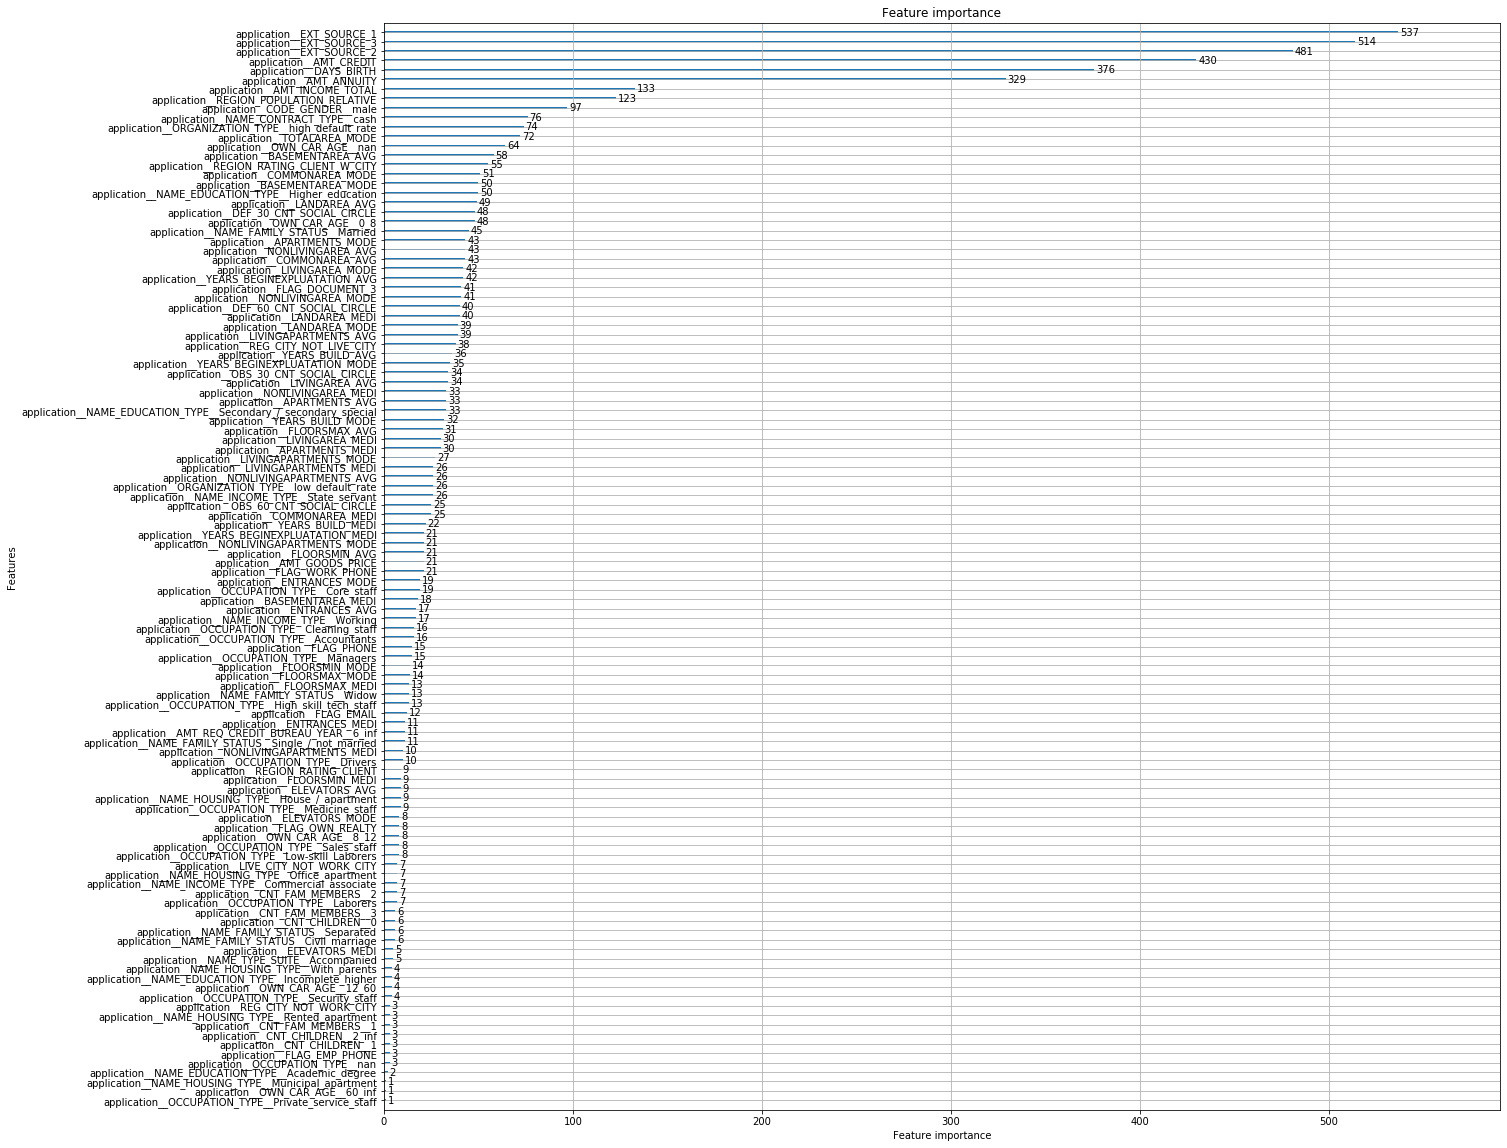

In [12]:
solve('application_ans.csv')